In [21]:
import mat73
import soundfile as sf
from IPython.display import Audio
import scipy.signal as sig
import numpy as np
import sofar
import scipy
import matplotlib.pyplot as plt


# V1: notch filter designed by hand

In [22]:
def bell(fc, fs, gain, Q):
    wc = 2 * np.pi * fc / fs
    c = 1.0 / np.tan(wc / 2.0)
    phi = c*c
    Knum = c / Q
    Kdenom = Knum

    if (gain > 1.0):
        Knum *= gain
    elif (gain < 1.0):
        Kdenom /= gain

    a0 = phi + Kdenom + 1.0

    b = [(phi + Knum + 1.0) / a0, 2.0 *
         (1.0 - phi) / a0, (phi - Knum + 1.0) / a0]
    a = [1, 2.0 * (1.0 - phi) / a0, (phi - Kdenom + 1.0) / a0]

    return np.asarray(b), np.asarray(a)

In [23]:
def shelving(fc, sr, gain, slope):
    omega= (fc / sr) * np.pi * 2.0
    sn= np.sin(omega)
    cs= np.cos(omega)
    alpha = sn / 2.0 * np.sqrt((gain + 1.0/gain) * (1.0/slope - 1.0) + 2.0)

    b=np.zeros(3) # umerator(bunsi)
    a=np.zeros(3) # denominator(bunbo)

    a[0]= ((gain + 1.0 ) - (gain - 1.0) * cs + 2.0 * np.sqrt(gain) * alpha)
    a[1]= 2.0 * (( gain - 1.0) - ( gain + 1.0) * cs)
    a[2]= ((gain + 1.0) - (gain - 1.0 ) * cs - 2.0 * np.sqrt( gain) * alpha )

    b[0]= gain * ((gain +1.0 ) + (gain - 1.0) * cs + 2.0 * np.sqrt(gain) * alpha )
    b[1]= -2.0 * gain * ((gain - 1.0) + (gain + 1.0 ) * cs)
    b[2]= gain * ((gain + 1.0) + (gain - 1.0) * cs - 2.0 * np.sqrt(gain) * alpha)

    b /= a[0]
    a /= a[0]

    return b, a

In [ ]:
os.listdir()

In [40]:
audio, fs = sf.read('/home/ubuntu/Data/microson_v1/train/reverberant/10013_9951_000001.wav')

In [41]:
Audio(audio.T, rate=fs)

In [42]:
ku100 = sofar.read_sofa('KU100_New_128_noALFE_cut_now.sofa')

In [43]:
ha = sofar.read_sofa('RIC_Front_Omni_128_noALFE_cut_now.sofa')

In [44]:
d2 = scipy.fft.ifft(scipy.fft.fft(np.mean(np.mean(ku100.Data_IR, axis=0), axis=0)) / scipy.fft.fft(np.mean(np.mean(ha.Data_IR, axis=0), axis=0)))

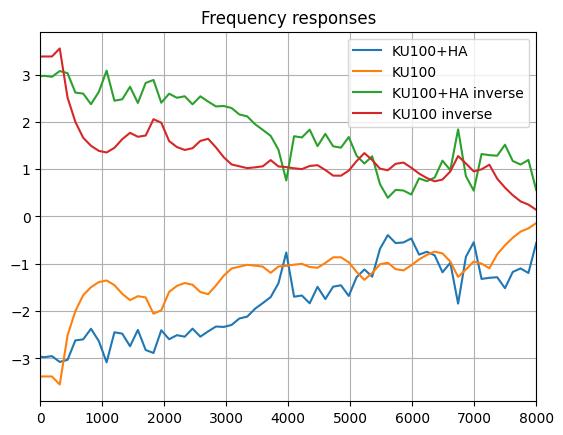

In [45]:
# We plot the inverse of the ku100_ha_test:

ku100_ha_test_f = scipy.fft.fft(np.mean(np.mean(ha.Data_IR, axis=0), axis=0))
ku100_test_f = scipy.fft.fft(np.mean(np.mean(ku100.Data_IR, axis=0), axis=0))



inv_ha_f = 1/ku100_ha_test_f
inv_f = 1/ku100_test_f

plt.plot(np.linspace(-8000, 8000, 128), np.log10(np.abs(ku100_ha_test_f)))
plt.plot(np.linspace(-8000, 8000, 128), np.log10(np.abs(ku100_test_f)))


plt.plot(np.linspace(-8000, 8000, 128), np.log10(np.abs(inv_ha_f)))
plt.plot(np.linspace(-8000, 8000, 128), np.log10(np.abs(inv_f)))
plt.title('Frequency responses')
plt.legend(['KU100+HA', 'KU100', 'KU100+HA inverse', 'KU100 inverse'])
plt.xlim([0 , 8000]);
plt.grid(True)

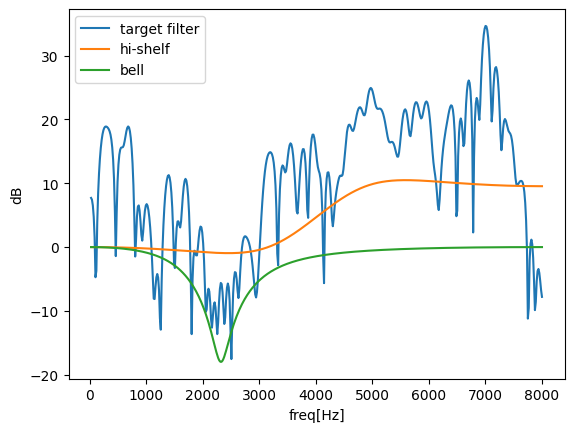

In [54]:
#b, a = sig.iirnotch(w0 = 2300, Q=1.8, fs=16000)
w, h = scipy.signal.freqz(np.real(d2))
plt.plot(np.linspace(20, 8000, 512), 20*np.log10(abs(h)))

#w2, h2 = scipy.signal.freqz(b,a)
#new_notch = np.array([sig.lfilter(b, a, audio[:, 0]), sig.lfilter(b, a, audio[:, 1])])
#plt.plot(np.linspace(20, 8000, 512), 20*np.log10(abs(h2)))
b_s, a_s = shelving(4000, 16000, np.sqrt(3.), 2.0)
w_s, h_s = sig.freqz(b_s, a_s)
plt.plot(np.linspace(20, 8000, 512), 20*np.log10(abs(h_s)))

b_hb, a_hb = bell(2300, 16000, np.power(10, -18/20), 8.)
w_hb, h_hb = sig.freqz(b_hb, a_hb)


plt.plot(np.linspace(20, 8000, 512), 20*np.log10(abs(h_hb)))

plt.legend(['target filter', 'hi-shelf', 'bell'])
plt.xlabel('freq[Hz]')
plt.ylabel('dB');

In [55]:
Audio(audio.T, rate=fs)

In [56]:
high_bell_filtered = np.array([sig.lfilter(b_hb, a_hb, audio[:, 0]), sig.lfilter(b_hb, a_hb, audio[:, 1])]).T
all_filtered = np.array([sig.lfilter(b_s, a_s, high_bell_filtered[:,0]), sig.lfilter(b_s, a_s, high_bell_filtered[:,1])]).T

Audio(all_filtered.T, rate=fs)

In [57]:
Audio(high_bell_filtered.T, rate=fs)

In [ ]:
sig.lfilter(np.real(d2), np.imag(d2), audio)

In [ ]:
Audio(a1, rate=fs)

In [ ]:
Audio(new_notch, rate=fs)

In [ ]:
audio.shape

In [ ]:
w, h = scipy.signal.freqz(np.real(d2))
plt.semilogx(np.linspace(20, 8000, 512), 20*np.log10(abs(h)))
w2, h2 = scipy.signal.freqz(b,a)
plt.semilogx(np.linspace(20, 8000, 512), 20*np.log10(abs(h2)))




In [ ]:
b, a = sig.iirnotch(w0 = 2500, Q=3.2, fs=16000)

w, h = scipy.signal.freqz(np.real(d2))
plt.plot(np.linspace(20, 8000, 512), 20*np.log10(abs(h)))
w2, h2 = scipy.signal.freqz(b,a)
new_notch = np.array([sig.lfilter(b, a, audio[:, 0]), sig.lfilter(b, a, audio[:, 1])])
plt.plot(np.linspace(20, 8000, 512), 20*np.log10(abs(h2)))




In [ ]:
new_notch2 = np.array([sig.filtfilt(b, a, audio[:, 0]), sig.filtfilt(b, a, audio[:, 1])])

In [ ]:
b, a = sig.iirnotch(w0 = 2300, Q=2.2, fs=16000)

w, h = scipy.signal.freqz(np.real(d2))
plt.plot(np.linspace(20, 8000, 512), 20*np.log10(abs(h)))
w2, h2 = scipy.signal.freqz(b,a)
new_notch = np.array([sig.lfilter(b, a, audio[:, 0]), sig.lfilter(b, a, audio[:, 1])])
plt.plot(np.linspace(20, 8000, 512), 20*np.log10(abs(h2)))



In [ ]:
Audio(new_notch, rate=fs)

In [ ]:
Audio(new_notch, rate=fs)

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return scipy.signal.butter(order, [lowcut, highcut], fs=fs, btype='band')

fs = 16000.0
lowcut = 2000.0
highcut = 3000.0
b, a = butter_bandpass(lowcut, highcut, fs, order=3)

In [ ]:
d1_bandpassed = scipy.signal.lfilter(b, a, d1)

In [ ]:
w, h = scipy.signal.freqz(d1_bandpassed)
plt.plot(np.linspace(20, 8000, 512), 20*np.log10(abs(h)))

In [ ]:
Audio(new_notch2, rate=fs)